In [166]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from DataLoader import DataLoader
import datetime
import random
import warnings
from BehaviourFeatureExtractor import BehaviourFeatureExtractor, plot_mouse_angle_to_pup, convert_seconds_to_frame
from VocalFeatureExtractor import VocalFeatureExtractor

## Reading Avisoft file - initial exploration ##

In [167]:
data_dir = "data"
DL = DataLoader(data_dir, path_to_config_file = "config.json")

Found items ['.DS_Store', 'MBI5335RR'] at directory data
Found items ['.DS_Store', 'MBI5335RR_240309_d6', 'MBI5335RR_240305_d2', 'MBI5335RR_240304_d1', 'MBI5335RR_240308_d5', 'MBI5335RR_240306_d3', 'MBI5335RR_240307_d4'] at directory data/MBI5335RR
Found items ['MBI5335RR_240309_d6_Avisoft', 'MBI5335RR_240309_d6_Behavior'] at directory data/MBI5335RR/MBI5335RR_240309_d6
Found items ['MBI5335RR_240309_d6_Avisoft_concatenated 2024-04-21  2_08 PM_Stats_SYNCCORRECTED.xlsx'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Avisoft
Found items ['MBI5335RR_d6DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.csv', 'MBI5335RR_240309_d6_BehavSummary.csv'] at directory data/MBI5335RR/MBI5335RR_240309_d6/MBI5335RR_240309_d6_Behavior
Found items ['MBI5335RR_240305_d2_Behavior', 'MBI5335RR_240305_d2_Avisoft'] at directory data/MBI5335RR/MBI5335RR_240305_d2
Found items ['MBI5335RR_240305_d2_BehavSummary.csv', 'MBI5335RR_d2DLC_resnet50_ESM-maternal-learningJun18shuffle1_100000.

##### Day 1 trials #####

In [168]:
# get data for d1 experiment
day = "d1"
day1_data = DL.get_data_for_experiment(mouse_id = "MBI5335RR",
                                       day = day)

# fill out dataframes
df_summary = day1_data['Behavior']['df_summary']
df_DLC = day1_data['Behavior']['df_dlc']
df_Avi = day1_data['Avisoft']['df']

# get one trial for the mouse
trial_num = 9
BF =  BehaviourFeatureExtractor("config.json")
trial_DLC, mask_DLC = BF.extract_trial_from_DLC(df_DLC, df_summary, trial_num = trial_num)

In [169]:
print(df_Avi.columns)
print("All vocalizations:", len(df_Avi))
df_Avi_USV = df_Avi[df_Avi['Accepted'] == True]

print("Accepted vocalizations:", len(df_Avi_USV))

Index(['File', 'ID', 'Label', 'Accepted', 'Score', 'BeginTime_s_',
       'EndTime_s_', 'CallLength_s_', 'PrincipalFrequency_kHz_',
       'LowFreq_kHz_', 'HighFreq_kHz_', 'DeltaFreq_kHz_',
       'FrequencyStandardDeviation_kHz_', 'Slope_kHz_s_', 'Sinuosity',
       'MeanPower_dB_Hz_', 'Tonality', 'PeakFreq_kHz_'],
      dtype='object')
All vocalizations: 290
Accepted vocalizations: 230


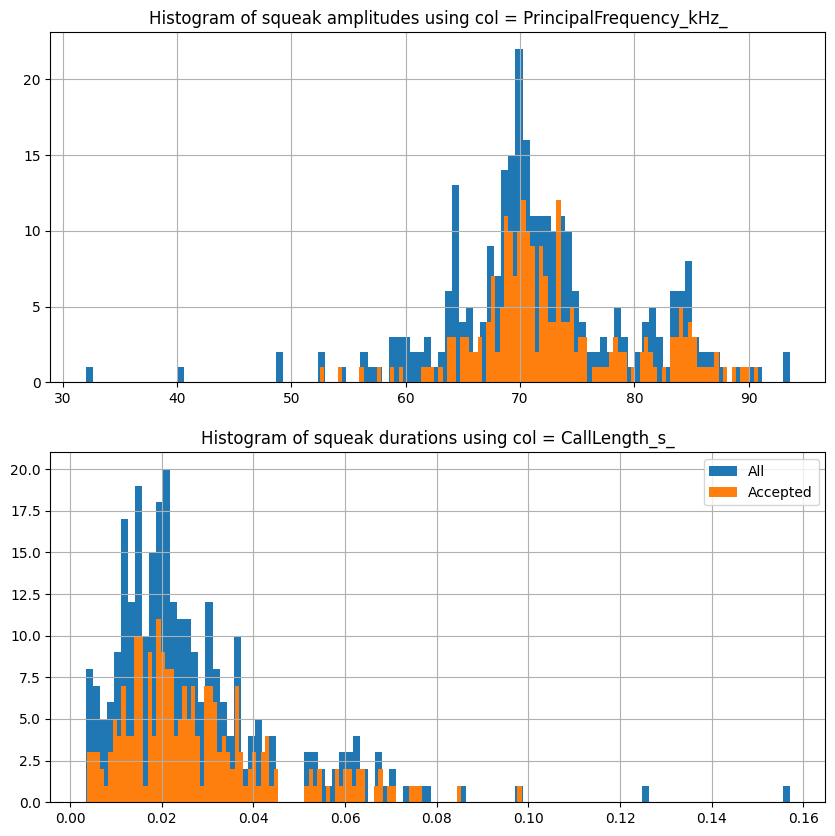

In [170]:
# histogram for squeak amplitudes
amplitude_col = "PrincipalFrequency_kHz_"

# create 2 figs
fig, ax = plt.subplots(2, 1, figsize = (10, 10))

df_Avi[amplitude_col].hist(bins = 100, ax = ax[0], label = "All")
df_Avi_USV[amplitude_col].hist(bins = 100, ax = ax[0], label = "Accepted")
ax[0].set_title("Histogram of squeak amplitudes using col = {}".format(amplitude_col))

# histogram for squeak durations
duration_col = "CallLength_s_"

df_Avi[duration_col].hist(bins = 100, ax = ax[1], label = "All")
df_Avi_USV[duration_col].hist(bins = 100, ax = ax[1], label = "Accepted")

ax[1].set_title("Histogram of squeak durations using col = {}".format(duration_col))
plt.legend()

Total number of calls per trial:  {1: 3, 2: 0, 3: 1, 4: 9, 5: 10, 6: 5, 7: 6, 8: 11, 9: 24, 10: 2} 
Total calls in session: 71
Total duration of trial:  {1: 15.504000000000019, 2: 6.1440000000000055, 3: 79.74400000000003, 4: 23.625999999999976, 5: 108.81700000000001, 6: 9.927999999999997, 7: 10.774999999999977, 8: 15.984000000000037, 9: 71.51999999999998, 10: 23.312000000000012}


Text(0.5, 1.0, 'Number of calls and duration of trial for each trial')

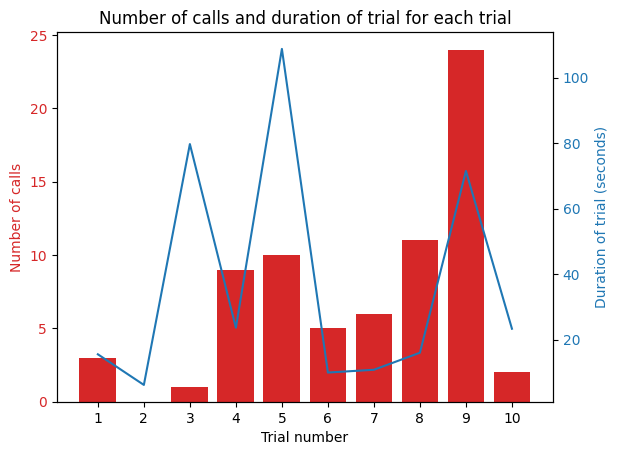

In [171]:
# makke a barplot of the number of calls per trial
calls_per_trial = {}
duration_per_trial = {}
tolerance_end_trial_seconds = 0

# get the trial begin and end times
for trial_num in df_summary['TrialNum'].unique():
    trial_begin_time = df_summary[df_summary['TrialNum'] == trial_num]['PupDispDropSecs'].values[0]    
    trial_end_time = df_summary[df_summary['TrialNum'] == trial_num]['BehavRecdTrialEndSecs'].values[0] + tolerance_end_trial_seconds
    # get the calls in the trial
    df_Avi_USV_trial = df_Avi_USV[(df_Avi_USV['BeginTime_s_'] >= trial_begin_time) & (df_Avi_USV['EndTime_s_'] <= trial_end_time)]
    # get number of calls contained in the trial
    num_calls = len(df_Avi_USV_trial)
    calls_per_trial[trial_num] = num_calls
    duration_per_trial[trial_num] = trial_end_time - trial_begin_time

print("Total number of calls per trial: ", calls_per_trial, "\nTotal calls in session:", sum(calls_per_trial.values()))
print("Total duration of trial: ", duration_per_trial)

# plot both the number of calls and the duration of the trial on different y axes
fig, ax1 = plt.subplots()

color = 'tab:red'

ax1.set_xlabel('Trial number')
ax1.set_ylabel('Number of calls', color=color)
ax1.bar(calls_per_trial.keys(), calls_per_trial.values(), color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('Duration of trial (seconds)', color=color)  # we already handled the x-label with ax1
ax2.plot(duration_per_trial.keys(), duration_per_trial.values(), color=color)
ax2.tick_params(axis='y', labelcolor=color)

#show all x values
ax1.set_xticks(list(calls_per_trial.keys()))

ax1.set_title("Number of calls and duration of trial for each trial")

Begin time: 380.2462568299203, End time: 380.2728848299203, Frequency: 74.17901624325262
Begin time: 380.95727187695314, End time: 380.97627987695313, Frequency: 75.4050925925926
Begin time: 381.31512955257375, End time: 381.33101755257377, Frequency: 75.06344274736743
Begin time: 486.6087138105469, End time: 486.6602898105469, Frequency: 68.79682410423453
Begin time: 519.9726882155109, End time: 520.0358002155108, Frequency: 64.36275407434537
Begin time: 520.7579890976563, End time: 520.7943850976562, Frequency: 73.5576923076923
Begin time: 521.8833168519099, End time: 521.8881008519098, Frequency: 73.52526246719161
Begin time: 522.1869171878308, End time: 522.2110851878308, Frequency: 73.55612704563968
Begin time: 522.4893415585938, End time: 522.5565415585937, Frequency: 71.92708333333333
Begin time: 522.833755890625, End time: 522.853819890625, Frequency: 84.55778301886792
Begin time: 522.9045945117188, End time: 522.9421785117188, Frequency: 72.60019083969466
Begin time: 523.71023

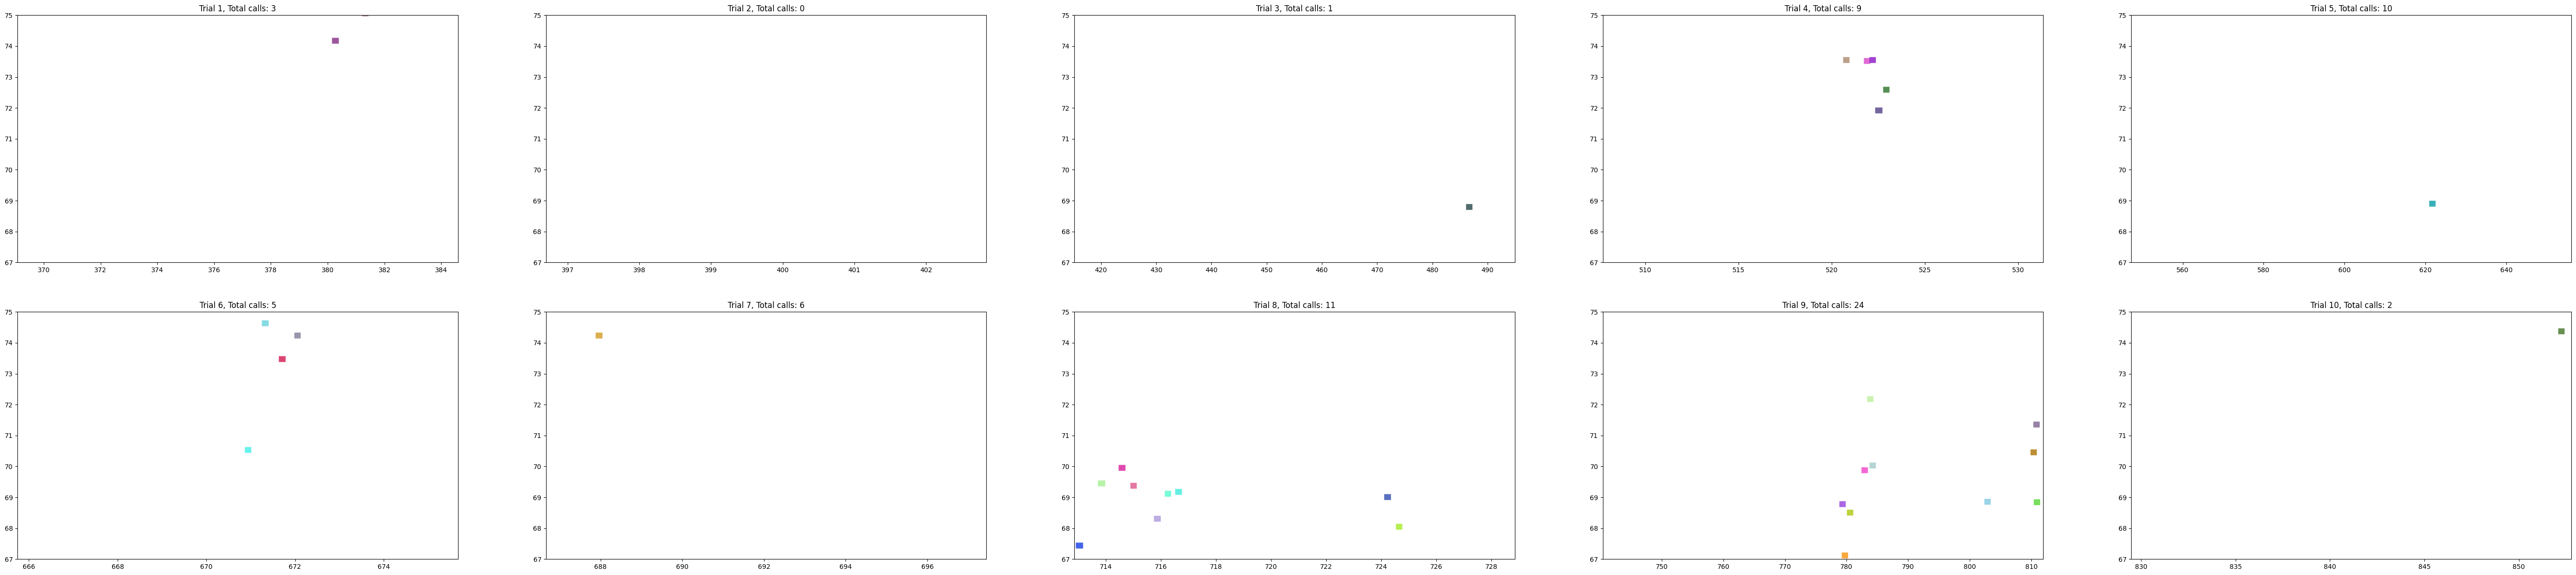

In [172]:
# trials_info = {}
fig, ax = plt.subplots(2, 5, figsize = (70, 15))

for trial_num in df_summary['TrialNum'].unique():
    # get the trial begin and end times
    trial_begin_time = df_summary[df_summary['TrialNum'] == trial_num]['PupDispDropSecs'].values[0]
    trial_end_time = df_summary[df_summary['TrialNum'] == trial_num]['BehavRecdTrialEndSecs'].values[0] + tolerance_end_trial_seconds

    # plot all of the calls with frequency on the y axis, time on the x axis, the call is a line draw between begin and end time 
    df_Avi_USV_trial = df_Avi_USV[(df_Avi_USV['BeginTime_s_'] >= trial_begin_time) & (df_Avi_USV['EndTime_s_'] <= trial_end_time)]
    for i, row in df_Avi_USV_trial.iterrows():
        # get the begin and end time of the call
        begin_time = row['BeginTime_s_']
        end_time = row['EndTime_s_']
        frequency = row[amplitude_col]
        # use a different color each time
        color = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
        ax[(trial_num-1)//5, (trial_num-1)%5].plot([begin_time, end_time], [frequency, frequency], color = color, linewidth = 9, alpha = 0.8)
        print("Begin time: {}, End time: {}, Frequency: {}".format(begin_time, end_time, frequency))

    min_freq, max_freq = 67, 75

    ax[(trial_num-1)//5, (trial_num-1)%5].set_title("Trial {}".format(trial_num) + ", Total calls: " + str(calls_per_trial[trial_num]))
    # tighten the y axis
    ax[(trial_num-1)//5, (trial_num-1)%5].set_ylim([min_freq, max_freq])
    ax[(trial_num-1)//5, (trial_num-1)%5].set_xlim([trial_begin_time, trial_end_time])
    # print total number of calls in legend in bottom right corner
    #ax[(trial_num-1)//5, (trial_num-1)%5].legend(["Total calls: " + str(calls_per_trial[trial_num])], loc = "lower right")


Begin time: 275.6333333333333, End time: 275.6666666666667, Frequency: 80.80818965517241
Begin time: 275.73333333333335, End time: 275.73333333333335, Frequency: 70.93472524711008
Begin time: 275.9, End time: 275.9, Frequency: 70.03584245000349
Begin time: 276.1, End time: 276.1, Frequency: 73.80933544303798
Begin time: 276.43333333333334, End time: 276.43333333333334, Frequency: 74.39905949256344
Begin time: 276.56666666666666, End time: 276.6, Frequency: 69.00201612903226
Begin time: 276.6666666666667, End time: 276.7, Frequency: 75.13888888888889
Begin time: 276.93333333333334, End time: 276.96666666666664, Frequency: 67.1531504890364
Begin time: 277.0333333333333, End time: 277.06666666666666, Frequency: 68.73883928571429
Begin time: 277.1333333333333, End time: 277.1333333333333, Frequency: 72.32743840487682
Begin time: 277.23333333333335, End time: 277.23333333333335, Frequency: 72.85458972233734
Begin time: 277.5333333333333, End time: 277.5333333333333, Frequency: 70.2121322005

Text(0.5, 0, 'Time (s)')

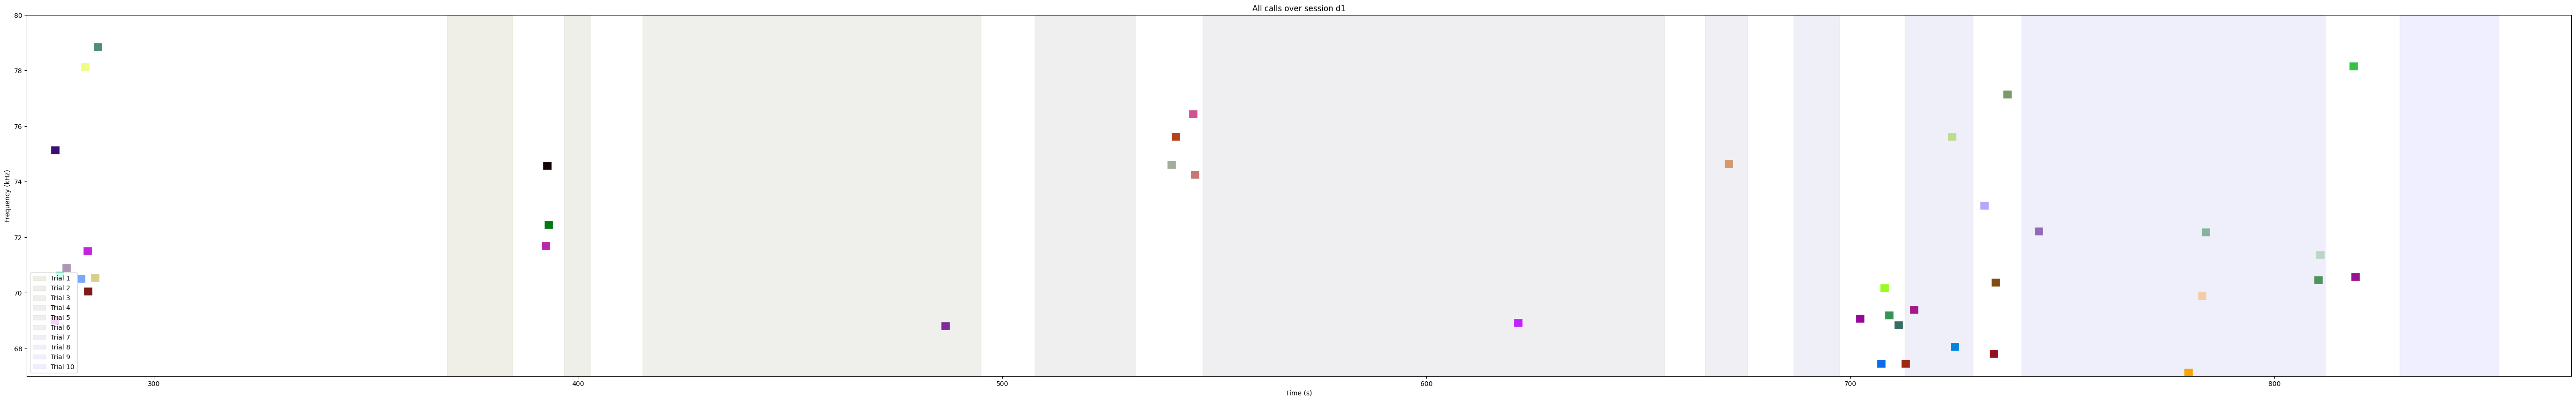

In [236]:
fig, ax = plt.subplots(1, 1, figsize = (70, 10))

for i, row in df_Avi_USV.iterrows():
    # get the begin and end time of the call
    begin_time = (row['BeginTime_s_'] // (1/30)) * (1/30)
    end_time = (row['EndTime_s_'] // (1/30)) * (1/30)
    frequency = row[amplitude_col]
    # use a different color each time
    color = (random.uniform(0, 1), random.uniform(0, 1), random.uniform(0, 1))
    ax.plot([begin_time, end_time], [frequency, frequency], color = color, linewidth = 12, alpha = 1)
    print("Begin time: {}, End time: {}, Frequency: {}".format(begin_time, end_time, frequency))

# for each trial, shade the area with a different colors between trial end and trial begin

for trial_num in df_summary['TrialNum'].unique():
    # get the trial begin and end times
    trial_begin_time = df_summary[df_summary['TrialNum'] == trial_num]['PupDispDropSecs'].values[0]
    trial_end_time = df_summary[df_summary['TrialNum'] == trial_num]['BehavRecdTrialEndSecs'].values[0]
    color = (0.4, 0.4, trial_num/10)
    ax.axvspan(trial_begin_time, trial_end_time, color = color, alpha = 0.1, label = "Trial {}".format(trial_num))

min_freq, max_freq = 67, 80
# tighten the y axis
ax.set_ylim([min_freq, max_freq])
ax.set_xlim([270, 870])
ax.set_title(f"All calls over session {day}")
ax.legend(loc = "lower left")
ax.set_ylabel("Frequency (kHz)")
ax.set_xlabel("Time (s)")

### Aligning time indices ###

First look

In [174]:
time_col_DLC = ['time_seconds', 'frame_index']
time_col_Avi = ['BeginTime_s_', 'EndTime_s_', 'CallLength_s_']

print("DLC :\n" + str(df_DLC[time_col_DLC]))
print("Avi :\n" + str(df_Avi_USV[time_col_Avi]))

DLC :
       time_seconds  frame_index
151        5.033333          151
152        5.066667          152
153        5.100000          153
154        5.133333          154
155        5.166667          155
...             ...          ...
26036    867.866667        26036
26037    867.900000        26037
26038    867.933333        26038
26039    867.966667        26039
26040    868.000000        26040

[25890 rows x 2 columns]
Avi :
     BeginTime_s_  EndTime_s_  CallLength_s_
12     275.659636  275.668276       0.008640
13     275.753306  275.763602       0.010296
14     275.926704  275.930304       0.003600
15     276.108306  276.121522       0.013216
16     276.436662  276.458142       0.021480
..            ...         ...            ...
277    818.599431  818.638303       0.038872
278    818.992148  819.013572       0.021424
279    819.049169  819.067385       0.018216
286    851.420343  851.451423       0.031080
287    852.224257  852.257185       0.032928

[230 rows x 3 columns]


Defining bout windows on DLC data, one time window $= 6 frames = 1/30 \times 6 s = 1/5 s = 200 ms$

In [175]:
trial_DLC["bout_window"] = -1
frames_grouped = 6 # 200 ms, 0.2 s
frames_grouped = 3 # 100 ms, 0.1 s
trial_DLC = trial_DLC.copy()

# 1. for every 6 frames in the trial, assign a bout index
for i in range(0, len(trial_DLC), frames_grouped):
    trial_DLC["bout_window"][i:i+frames_grouped] = i//frames_grouped

trial_DLC[time_col_DLC + ["bout_window"]]

,time_seconds,frame_index,bout_window
22212,740.400000,22212,0
22213,740.433333,22213,0
22214,740.466667,22214,0
22215,740.500000,22215,1
22216,740.533333,22216,1
...,...,...,...
24354,811.800000,24354,714
24355,811.833333,24355,714
24356,811.866667,24356,714
24357,811.900000,24357,715


 Determine the bout index that the USV belong to

In [214]:
def most_frequent(l:np):
    l = l.tolist()
    return max(set(l), key=l.count)

# 1. filter the USV by begin and end time to make sure they belong to the trial
average_call_length = df_Avi_USV['CallLength_s_'].mean()
print("Average call length:", average_call_length)
tolerance = average_call_length
trial_end_time = trial_DLC['time_seconds'].max()
trial_begin_time = trial_DLC['time_seconds'].min()

df_Avi_USV_trial = df_Avi_USV[(df_Avi_USV['BeginTime_s_'] >= trial_begin_time) & (df_Avi_USV['EndTime_s_'] <= trial_end_time)]
# print number of calls contained in the trial
print("Total number of calls in trial: ", len(df_Avi_USV_trial))

# 2. for every USV, assign a bout index
df_Avi_USV_trial["bout_window"] = -1

for i in range(len(df_Avi_USV_trial)):
    
    row = df_Avi_USV_trial.iloc[i]
    begin_time_usv = row['BeginTime_s_']
    end_time_usv = row['EndTime_s_']
    duration = row['CallLength_s_']

    begin_time_usv_frame = convert_seconds_to_frame(begin_time_usv, 30)
    end_time_usv_frame = convert_seconds_to_frame(end_time_usv, 30)

    print("Begin time: {}, End time: {}, Duration: {}".format(begin_time, end_time, duration))
    print("Begin time frame: {}, End time frame: {}".format(begin_time_usv_frame, end_time_usv_frame))

    bout_window = trial_DLC[(trial_DLC['time_seconds'] >= begin_time_usv) & (trial_DLC['time_seconds'] <= end_time_usv)]['bout_window'].values
    bout_window = trial_DLC[(trial_DLC['frame_index'] >= begin_time_usv_frame) & (trial_DLC['frame_index'] <= end_time_usv_frame)]['bout_window'].values

    print("bout window = ", bout_window)
    if len(bout_window) > 0:
        # pick most frequent bout window
        most_frequent_index = most_frequent(bout_window)
        print("most_frequent_index = ", most_frequent_index)
        print("index = ", i)
        df_Avi_USV_trial['bout_window'].iloc[i] = most_frequent_index


Average call length: 0.02808975652174334
Total number of calls in trial:  24
Begin time: 744.4291151382101, End time: 744.4406751382102, Duration: 0.006160000000022592
Begin time frame: 22321, End time frame: 22321
bout window =  [36]
most_frequent_index =  36
index =  0
Begin time: 744.4291151382101, End time: 744.4406751382102, Duration: 0.011560000000031323
Begin time frame: 22333, End time frame: 22333
bout window =  [40]
most_frequent_index =  40
index =  1
Begin time: 744.4291151382101, End time: 744.4406751382102, Duration: 0.023700000000076216
Begin time frame: 23061, End time frame: 23062
bout window =  [283 283]
most_frequent_index =  283
index =  2
Begin time: 744.4291151382101, End time: 744.4406751382102, Duration: 0.02777600000001712
Begin time frame: 23379, End time frame: 23380
bout window =  [389 389]
most_frequent_index =  389
index =  3
Begin time: 744.4291151382101, End time: 744.4406751382102, Duration: 0.04270399999995789
Begin time frame: 23391, End time frame: 2

In [209]:
# print begin and end of trial
print("Begin time of trial: ", trial_begin_time)
print("End time of trial: ", trial_end_time)


trial_DLC[time_col_DLC + ["bout_window"]].iloc[100:120] 

Begin time of trial:  740.4
End time of trial:  811.9333333333333


,time_seconds,frame_index,bout_window
22312,743.733333,22312,33
22313,743.766667,22313,33
22314,743.800000,22314,34
22315,743.833333,22315,34
22316,743.866667,22316,34
22317,743.900000,22317,35
22318,743.933333,22318,35
22319,743.966667,22319,35
22320,744.000000,22320,36
22321,744.033333,22321,36


In [215]:
df_Avi_USV_trial[time_col_Avi + ["bout_window"]]


,BeginTime_s_,EndTime_s_,CallLength_s_,bout_window
250,744.039161,744.045321,0.006160,36
251,744.429115,744.440675,0.011560,40
252,768.696196,768.719896,0.023700,283
253,779.290712,779.318488,0.027776,389
254,779.688458,779.731162,0.042704,393
255,779.840662,779.875382,0.034720,394
256,780.518241,780.540721,0.022480,401
257,781.513056,781.536728,0.023672,411
258,781.541765,781.577645,0.035880,411
259,782.556380,782.591740,0.035360,421


Average computations on bout windows

In [220]:
# group usv trial by bout window

df_Avi_USV_trial_grouped = df_Avi_USV_trial.groupby("bout_window").agg({"BeginTime_s_": "min", "EndTime_s_": "max", "CallLength_s_": "mean", "PrincipalFrequency_kHz_": "mean", "bout_window": "count"})

# renames the columns
df_Avi_USV_trial_grouped.columns = ["BeginTime_s_min", "EndTime_s_max", "CallLength_s_avg", "PrincipalFrequency_kHz_avg", "Number of calls"]



In [221]:
# iterate over the groups and print the dataframes

df_Avi_USV_trial_grouped


,BeginTime_s_min,EndTime_s_max,CallLength_s_avg,PrincipalFrequency_kHz_avg,Number of calls
bout_window,,,,,
36,744.039161,744.045321,0.006160,81.221719,1
40,744.429115,744.440675,0.011560,72.206591,1
283,768.696196,768.719896,0.023700,70.323049,1
389,779.290712,779.318488,0.027776,68.784722,1
393,779.688458,779.731162,0.042704,67.129031,1
394,779.840662,779.875382,0.034720,64.122737,1
401,780.518241,780.540721,0.022480,68.515839,1
411,781.513056,781.577645,0.029776,79.917594,2
421,782.556380,782.591740,0.035360,82.514077,1


In [233]:
# within trial_DLC for each bout window, insert the number of calls, the average frequency and the average duration of the calls

trial_DLC["Number of calls"] = np.nan
trial_DLC["PrincipalFrequency_kHz_avg"] = np.nan
trial_DLC["CallLength_s_avg"] = np.nan

for bout_window in trial_DLC["bout_window"].unique():
    df_Avi_USV_trial_grouped_bout = df_Avi_USV_trial_grouped[df_Avi_USV_trial_grouped.index == bout_window]
    if len(df_Avi_USV_trial_grouped_bout) > 0:
        trial_DLC.loc[trial_DLC['bout_window'] == bout_window, "Number of calls"] = df_Avi_USV_trial_grouped_bout["Number of calls"].values[0]
        trial_DLC.loc[trial_DLC['bout_window'] == bout_window, "PrincipalFrequency_kHz_avg"] = df_Avi_USV_trial_grouped_bout["PrincipalFrequency_kHz_avg"].values[0]
        trial_DLC.loc[trial_DLC['bout_window'] == bout_window, "CallLength_s_avg"] = df_Avi_USV_trial_grouped_bout["CallLength_s_avg"].values[0]

trial_DLC[time_col_DLC + ["bout_window", "Number of calls", "PrincipalFrequency_kHz_avg", "CallLength_s_avg"]].iloc[105:125]

,time_seconds,frame_index,bout_window,Number of calls,PrincipalFrequency_kHz_avg,CallLength_s_avg
22317,743.900000,22317,35,NaN,NaN,NaN
22318,743.933333,22318,35,NaN,NaN,NaN
22319,743.966667,22319,35,NaN,NaN,NaN
22320,744.000000,22320,36,1.0,81.221719,0.00616
22321,744.033333,22321,36,1.0,81.221719,0.00616
22322,744.066667,22322,36,1.0,81.221719,0.00616
22323,744.100000,22323,37,NaN,NaN,NaN
22324,744.133333,22324,37,NaN,NaN,NaN
22325,744.166667,22325,37,NaN,NaN,NaN
22326,744.200000,22326,38,NaN,NaN,NaN
